# Assignment 9

Use data from `https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip`  
Implement model in pytorch from "An Unsupervised Neural Attention Model for Aspect Extraction, He et al, 2017", also desribed in seminar notes.  

You can use sentence embeddings with attention **[7 points]**:  
$z_s = \sum_{i}^n \alpha_i e_{w_i}, z_s \in R^d$ sentence embedding  
$\alpha_i = softmax(d_i)$  attention weight for i-th token  
$d_i = e_{w_i}^T M y_s$ attention with trainable matrix $M \in R^{dxd}$  
$y_s = \frac 1 n \sum_{i=1}^n e_{w_i}, y_s \in R^d$ sentence context  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  

**Or** just use sentence embedding as an average over word embeddings **[5 points]**:  
$z_s = \frac 1 n \sum_{i=1}^n e_{w_i}, z_s \in R^d$ sentence embedding  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  
 
$p_t = softmax(W z_s + b), p_t \in R^K$ topic weights for sentence $s$, with trainable matrix $W \in R^{dxK}$ and bias vector $b \in R^K$  
$r_s = T^T p_t, r_s \in R^d$ reconstructed sentence embedding as a weighted sum of topic embeddings   
$T \in R^{Kxd}$ trainable matrix of topic embeddings, K=number of topics


**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^n max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm


**[3 points]** Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

In [0]:
# TODO Заменить texts[23] на что-то более разумное при выборе негативных экземпляров
# TODO Заменить в TabularDataset, чтобы neg_{} зависило от NEG_SAMPLES
# TODO Сделать в модели так, чтобы neg не было фиксированным, а зависело от NEG_SAMPLES
# TODO Определить и проверить структуру Лосса.

In [0]:
import pandas as pd
import numpy as np

import nltk
import spacy 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vectors
from gensim.models import Word2Vec, KeyedVectors

nltk.download('punkt')
spacy_en = spacy.load('en')

In [0]:
BATCH_SIZE = 512
NEG_SAMPLES = 3  # number of negative samples
random_state = 23
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Making DataFrame 

In [0]:
!wget -O data.zip https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true
!unzip '/content/data.zip'

In [0]:
with open('/content/data.txt', 'r') as f:
    data = nltk.tokenize.sent_tokenize(f.read())

with open('/content/stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()

In [5]:
print(len(data), data[0])
print(len(stopwords), stopwords[0])

183400 Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-financial crisis boom years.
350 a


In [0]:
def create_df(texts, neg_samples):
    """
    Creating pandas DataFrame from texts and adding randomly chosen negative samples
    """
    df = pd.DataFrame()
    df['text'] = texts

    for i in range(1, neg_samples+1):
        df['neg_{}'.format(i)] = [texts[ind] if ind != el else texts[23] for el, ind in enumerate(np.random.choice(np.arange(0,len(texts)), size=len(texts)))]
    return df

In [0]:
df = create_df(data, neg_samples=NEG_SAMPLES)

In [8]:
df.head()

,text,neg_1,neg_2,neg_3
0,Barclays' defiance of US fines has merit Barcl...,"It was so long, and it was on every week.","For musicians, too, the hangups of peers and f...",Villa can’t get out of their own half.
1,"So it is tempting to think the bank, when aske...","In the 1990 movie Havana, you can see Arkin an...","If you’d asked me six months ago, I’d have sai...","But as Twitter’s experience shows, it’s hard t..."
2,"That is not the view of the chief executive, J...","Thanks, and goodnight (and enjoy the holidays,...",The condition was much more prevalent in publi...,Two of the things that the EU was once meant t...
3,Barclays thinks the DoJ’s claims are “disconne...,60 min: Firmino shoots.,Flemish is the language of the rich people.” B...,Rappers such as the Notorious BIG (who was men...
4,"But actually, some grudging respect for Staley...",Roger Ailes is not coaching Donald Trump for d...,I will stand by the mandate from this campaign...,Dikötter predicted that China’s leaders would ...


In [9]:
df.tail()

,text,neg_1,neg_2,neg_3
183395,It feels as though Stone realised that some of...,As the London-listed bank reported its third q...,The 19 countries in the eurozone have had a ne...,“These women were told that their dreams were ...
183396,"There are some fun elements, many involving Rh...",I don’t take back anything I said in that camp...,I have lost count of the number of times that ...,Of all the incongruous links between music and...
183397,I particularly enjoyed a scene in which O’Bria...,And at the heart of it was what seemed to be a...,"It is fallingforyou, a slow-burning track off ...",The asked readers in Northern Ireland and the ...
183398,His carnivorous snarl fills the immense screen...,It was for USA that Miazga first caught the ey...,And one of the best ways of predicting a perso...,Boles paused.
183399,There’s a playful visual flair to this moment ...,Kimmel posed a question to Sanders he said was...,Losses.,“The rate of imprisonment of Aboriginal people...


In [0]:
df.to_csv('data.csv', index=False)

# Dataset and Iterator

In [0]:
def tokenize(text):
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [12]:
# Using data to pretrain word-embeddings

data_tokenized = list(df['text'].apply(lambda x: tokenize(x)))
model = Word2Vec(data_tokenized, size=200, window=10, negative=5)  # building emb of size 200 (parameters from the paper)
model_weights = torch.FloatTensor(model.wv.vectors)
model.wv.save_word2vec_format('pretrained_embeddings')
vectors = Vectors(name='pretrained_embeddings', cache='./')  # and saving the weights to build vocab later

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
 96%|█████████▌| 23176/24240 [00:01<00:00, 12870.76it/s]


In [0]:
TEXT = Field(sequential=True, 
             include_lengths=False, 
             batch_first=True, 
             tokenize=tokenize, 
             lower=True, 
             stop_words=stopwords)

dataset = TabularDataset(
           path="/content/data.csv",
           format='csv',
           skip_header=True,
           fields=[('text', TEXT),('neg_1', TEXT), ('neg_2', TEXT), ('neg_3', TEXT)])

TEXT.build_vocab(dataset, min_freq=2, vectors=vectors,
                   unk_init = torch.Tensor.normal_)

In [0]:
vocab = TEXT.vocab

In [16]:
print('Vocab size:', len(TEXT.vocab.itos))

Vocab size: 55984


In [0]:
train, test = dataset.split(0.8)
train, valid = train.split(0.8)

In [0]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    shuffle=True,
    sort_key=lambda x: len(x.text),
    device=device
)

In [19]:
b = next(iter(valid_iterator))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'neg_1', 'neg_2', 'neg_3'])

In [20]:
b.text.size(), b.neg_1.size(), b.neg_2.size(), b.neg_3.size()

(torch.Size([512, 1]),
 torch.Size([512, 41]),
 torch.Size([512, 68]),
 torch.Size([512, 58]))

# Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class MyModel(nn.Module):

    def __init__(self, vocab_size, embed_size, topics_size):
        super(MyModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.topics_size = topics_size

        self.embeddings = nn.Embedding(self.vocab_size, self.embed_size)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.requires_gra = False  # For now let's freeze them

        self.fc1 = nn.Linear(self.embed_size, self.topics_size)  # W
        self.fc2 = nn.Linear(self.topics_size, self.embed_size)  # T


    def sentence_embeddings(self, x):
        '''
        input: (batch_size, seq_length, embed_size)
        output: (batch_size, embed_size)
        '''
        x = torch.sum(x, dim=1)/x.size()[1]
        return x

    
    def forward(self, batch):
        
        text, neg_1, neg_2, neg_3 = batch.text, batch.neg_1, batch.neg_2, batch.neg_3

        text_true = self.sentence_embeddings(self.embeddings(text))
        neg_1 = self.sentence_embeddings(self.embeddings(neg_1))
        neg_2 = self.sentence_embeddings(self.embeddings(neg_2))
        neg_3 = self.sentence_embeddings(self.embeddings(neg_3))

        
        text_out = self.fc1(text_true)
        text_out = F.softmax(text_out, dim=1)
        text_out = self.fc2(text_out)

        return text_true, text_out, neg_1, neg_2, neg_3

In [0]:
model = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=5)
model.to(device)
optimizer = optim.Adam(model.parameters())

In [129]:
tr, out, n1, n2, n3 = model.forward(b)

tr.size(), out.size(), n1.size(), n2.size(), n3.size()

(torch.Size([512, 200]),
 torch.Size([512, 200]),
 torch.Size([512, 200]),
 torch.Size([512, 200]),
 torch.Size([512, 200]))

In [130]:
loss_batch = 0 
for ind, truth in enumerate(tr): # Проходимся по батчу
    # print(truth.size())
    temp = 1 - torch.dot(out[ind].T, tr[ind]) + torch.dot(out[ind].T, n1[ind]) + torch.dot(out[ind].T, n2[ind]) + torch.dot(out[ind].T, n3[ind])
    # print(temp.size(), temp)
    t_max = F.relu(temp)
    # print(t_max)
    loss_batch += t_max
    # break
loss_batch / BATCH_SIZE

tensor(0.7733, device='cuda:0', grad_fn=<DivBackward0>)

**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^n max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm

In [0]:
# https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

class LossFunction(nn.Module):

    def __init__(self):
        super(LossFunction, self).__init__()

    def forward(self, emb_true, emb_pred, n1, n2, n3, T, lambd=1):

        loss_batch = 0
        for ind, e_true in enumerate(emb_true): # Проходимся по батчу
            temp = 1 - torch.dot(emb_pred[ind].T, e_true) + torch.dot(emb_pred[ind].T, n1[ind]) + torch.dot(emb_pred[ind].T, n2[ind]) + torch.dot(emb_pred[ind].T, n3[ind])
            t_max = F.relu(temp)
            loss_batch += t_max
        loss_batch += lambd * torch.norm(torch.mm(T.T, T) - torch.eye(T.size()[1], T.size(1)).to(device))
        return loss_batch / BATCH_SIZE

In [132]:
criterion = LossFunction()
criterion.to(device)

LossFunction()

In [0]:
train_losses = []
valid_losses = []

def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        text_true, text_out, neg_1, neg_2, neg_3 = model(batch)
        loss = criterion(text_true, text_out, neg_1, neg_2, neg_3, model.fc2.weight)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        
        # loss_smoothing = i / (i+1)
        # running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        train_losses.append(curr_loss)
        iterator.set_postfix(loss='%.5f' % curr_loss)

    return running_loss


def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            text_true, text_out, neg_1, neg_2, neg_3 = model(batch)
            loss = criterion(text_true, text_out, neg_1, neg_2, neg_3, model.fc2.weight)
            epoch_loss += loss.data.item()
            valid_losses.append(loss)

    return epoch_loss / n_batches


def nn_train(model, train_iterator, valid_iterator, optimizer, criterion, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, criterion,  epoch)
        valid_loss = _test_epoch(model, valid_iterator, criterion)
        # scheduler.step(valid_loss)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)

# nn_train(model, train_loader, valid_loader, optimizer, n_epochs=100) # Удалила вывод, т.к. он длинный, график лосса ниже

In [136]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=15) # Удалила вывод, т.к. он длинный, график лосса ниже

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



validation loss 0.16393



validation loss 0.11885



validation loss 0.09516



validation loss 0.08537



validation loss 0.07290



validation loss 0.05900



validation loss 0.05795



validation loss 0.05488



validation loss 0.05240



validation loss 0.05242



validation loss 0.05243



validation loss 0.05243



validation loss 0.04715



validation loss 0.04568



validation loss 0.04188


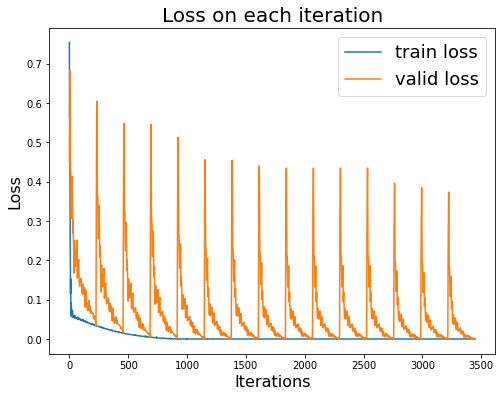

In [137]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Topic CoHerence

Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

In [0]:
topic_models = []

In [0]:
# topics = [5, 10, 15]

# for k in tqdm(topics):
#     # model = TruncatedSVD(n_components=k ) 
#     # W = model.fit_transform( A ) (n_samples, n_components)
#     # H = model.components_    (n_componens, n_features) n_features = 200

#     print(model_5.fc1.weight.size()) # H
#     print(model_5.fc2.weight.size())
#     print(model_5.embeddings.weight.size())

#     c = torch.mm(model_5.embeddings.weight, model_5.fc2.weight) # W
#     print(c.size())

#     # topic_models.append( (k,W,H) )
#     break

## Topic coherence for 5 topics

In [33]:
model_5 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=5)
model_5.to(device)
optimizer_5 = optim.Adam(model_5.parameters())
criterion_5 = LossFunction()
criterion_5.to(device)

LossFunction()

In [34]:
train_losses = []
valid_losses = []
nn_train(model_5, train_iterator, valid_iterator, optimizer_5, criterion_5, n_epochs=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



validation loss 0.07012



validation loss 0.04116



validation loss 0.03317



validation loss 0.02431



validation loss 0.02214


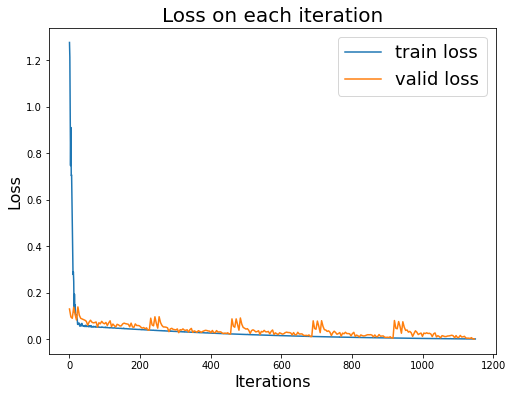

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_5.fc1.weight
W  = torch.mm(model_5.embeddings.weight, model_5.fc2.weight)
k = 5

topic_models.append( (k,W,H) )

## Topic coherence for 10 topics

In [38]:
model_10 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=10)
model_10.to(device)
optimizer_10 = optim.Adam(model_10.parameters())
criterion_10 = LossFunction()
criterion_10.to(device)

LossFunction()

In [39]:
train_losses = []
valid_losses = []
nn_train(model_10, train_iterator, valid_iterator, optimizer_10, criterion_10, n_epochs=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



validation loss 0.11819



validation loss 0.07825



validation loss 0.05762



validation loss 0.04805



validation loss 0.04621


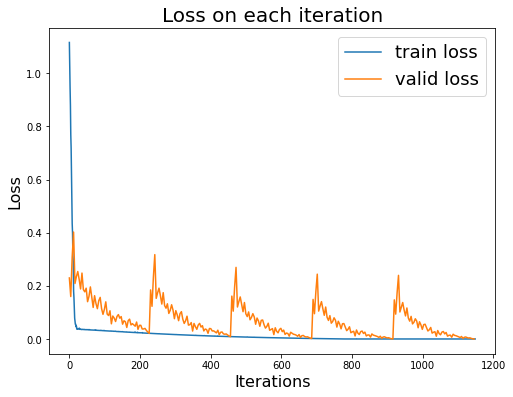

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_10.fc1.weight
W  = torch.mm(model_10.embeddings.weight, model_10.fc2.weight)
k = 10

topic_models.append( (k,W,H) )

## Topic coherence for 15 topics

In [41]:
model_15 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=15)
model_15.to(device)
optimizer_15 = optim.Adam(model_15.parameters())
criterion_15 = LossFunction()
criterion_15.to(device)

LossFunction()

In [42]:
train_losses = []
valid_losses = []
nn_train(model_15, train_iterator, valid_iterator, optimizer_15, criterion_15, n_epochs=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



validation loss 0.09366



validation loss 0.05304



validation loss 0.04387



validation loss 0.03781



validation loss 0.03304


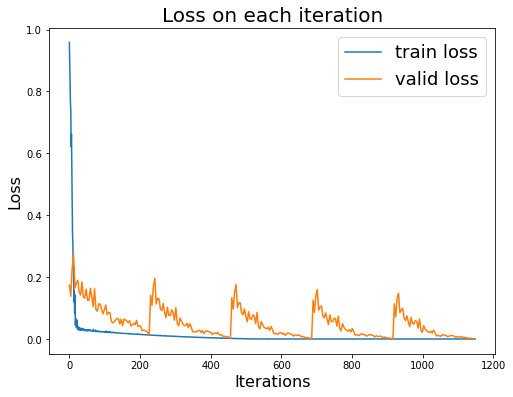

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_15.fc1.weight
W  = torch.mm(model_15.embeddings.weight, model_15.fc2.weight)
k = 15

topic_models.append( (k,W,H) )

## End of block

In [0]:
topics = [5, 10, 15]

In [0]:
def get_descriptor(terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor(vocab, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

In [56]:
from itertools import combinations


def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence(model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

NameError: ignored

In [55]:
type(model)

gensim.models.word2vec.Word2Vec